# Imports 

In [1]:
import math
import os
import json
import urllib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from sklearn import metrics
from neuraxle.base import ExecutionContext, DEFAULT_CACHE_FOLDER, ExecutionMode, BaseStep, NonFittableMixin
from neuraxle.api.flask import FlaskRestApiWrapper
from neuraxle.hyperparams.space import HyperparameterSamples
from neuraxle.pipeline import MiniBatchSequentialPipeline, Joiner, Pipeline
from neuraxle.steps.encoding import OneHotEncoder
from neuraxle.steps.output_handlers import OutputTransformerWrapper

from data_reading import DATASET_PATH, TRAIN, TEST, X_train_signals_paths, X_test_signals_paths, load_X, load_y, \
    TRAIN_FILE_NAME, TEST_FILE_NAME, LABELS
from pipeline import HumanActivityRecognitionPipeline, BATCH_SIZE
from steps.custom_json_decoder_for_2darray import CustomJSONDecoderFor2DArray
from steps.custom_json_encoder_of_outputs import CustomJSONEncoderOfOutputs
from savers.tensorflow1_step_saver import TensorflowV1StepSaver  # TODO: move in a package neuraxle-tensorflow.

# Read Data

In [2]:
DATA_PATH = "data/"
DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"

# X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

# y_train_path = os.path.join(DATASET_PATH, TRAIN, TRAIN_FILE_NAME)
y_test_path = os.path.join(DATASET_PATH, TEST, TEST_FILE_NAME)

# y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


# API Caller 

In [3]:
class APICaller(NonFittableMixin, BaseStep):
    def __init__(self, url):
        BaseStep.__init__(self)
        self.url = url
        
    def transform(self, data_inputs):
        data = json.dumps(data_inputs.tolist()).encode('utf8')
        req = urllib.request.Request(
            self.url,
            method="GET",
            headers={'content-type': 'application/json'},
            data=data
        )
        response = urllib.request.urlopen(req)
        test_predictions = json.loads(response.read())
        return np.array(test_predictions['predictions'])

# Call Rest Api 

In [4]:
p = Pipeline([
    APICaller(url="http://127.0.0.1:5000/")
])
y_pred = p.transform(X_test)
print(y_pred)

[[-1.00376022 -3.22574663 -1.74762106 -0.1013099   0.61165339 -5.02736664]
 [-0.90527415 -3.20171666 -1.81338     0.0932436   0.75021946 -4.88879108]
 [-0.89485669 -3.16932821 -1.80476213  0.04580438  0.77750677 -4.89109993]
 ...
 [ 4.41215801  6.99871826  2.78054214  1.71619391  0.72097886  2.2889092 ]
 [ 3.51318192  6.10547161  1.43138313  2.56595802  1.21157002  0.62227172]
 [ 3.96033239  5.9378233   3.445261    0.99932408  1.05689049 -0.02206901]]


# Plot 

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.



Precision: 73.67085664926599%
Recall: 72.54835425856804%
f1_score: 72.63862952734833%

Confusion Matrix:
[[285 128  67   9   7   0]
 [ 73 334  60   4   0   0]
 [115  76 211  13   5   0]
 [  3  25   0 419  44   0]
 [  6  11   5 131 379   0]
 [  0  27   0   0   0 510]]

Confusion matrix (normalised to % of total test data):
[[ 9.670852    4.3434      2.2734985   0.3053953   0.2375297   0.        ]
 [ 2.4770954  11.333559    2.0359688   0.13573125  0.          0.        ]
 [ 3.9022737   2.578894    7.1598234   0.44112659  0.16966406  0.        ]
 [ 0.10179844  0.8483203   0.         14.217849    1.4930438   0.        ]
 [ 0.20359688  0.37326095  0.16966406  4.4451985  12.860537    0.        ]
 [ 0.          0.916186    0.          0.          0.         17.305735  ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


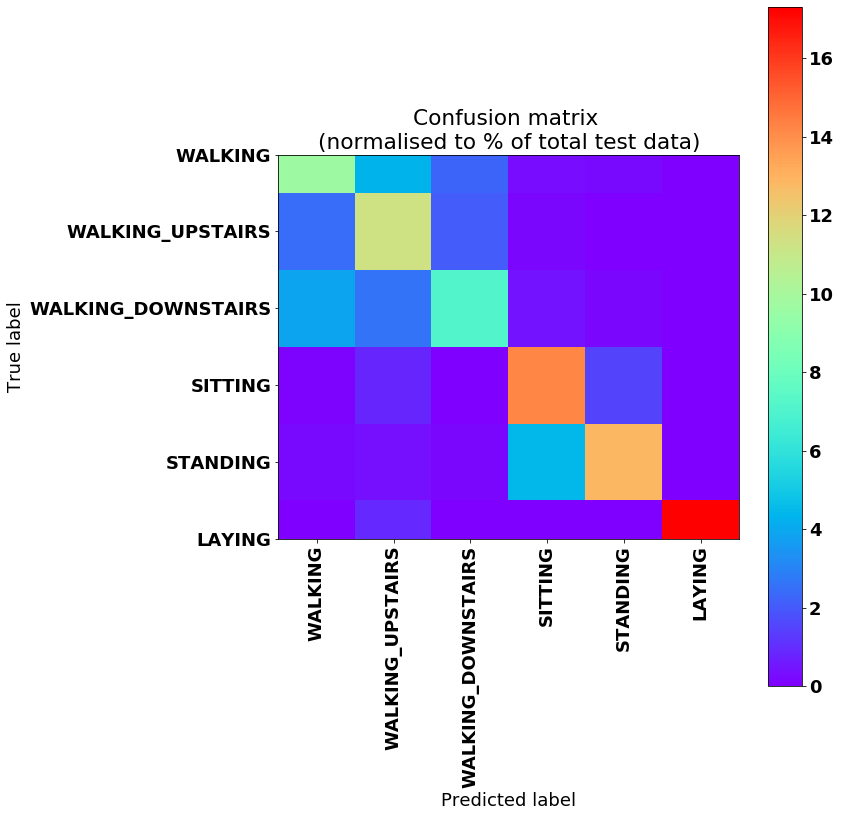

In [5]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

# Results

predictions = y_pred.argmax(1)
n_classes = 6

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results:
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix,
    interpolation='nearest',
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [6]:
p.teardown()

Pipeline
(
	Pipeline(
	name=Pipeline,
	hyperparameters=HyperparameterSamples()
)(
		[('APICaller',
  APICaller(
	name=APICaller,
	hyperparameters=HyperparameterSamples()
))]	
)
)